camera calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import logging
%matplotlib inline

In [2]:
import logging, sys


def init_logging(disable=''):
    
    #--- ref: code taken from: https://docs.python.org/3/howto/logging-cookbook.html
    #--- ref: and https://stackoverflow.com/a/9321890
    logger = logging.getLogger()

    if (logger.hasHandlers()):
        logger.handlers.clear()
        
    #--- filehandler logger
    filehandler = logging.FileHandler('adv_lane_find.log')
    #--- logging level set to DEBUG will result in a log a bunch of DEBUG info from PIL
    filehandler.setLevel(logging.INFO)
    filehandler_formatter = logging.Formatter('%(asctime)s | %(levelname)-8s | %(name)s: %(message)s')
    filehandler.setFormatter(filehandler_formatter)
    
    #--- console: INFO only, abbreviated format
    console = logging.StreamHandler(sys.stdout)
    console.setLevel(logging.INFO)
    console_formatter = logging.Formatter('%(levelname)-8s | %(name)s: %(message)s')
    console.setFormatter(console_formatter)
    
    logger.addHandler(console)
    logger.addHandler(filehandler)
    
    if disable:
        logging.disable(disable)
    
    return


class ChessboardImage:
    
    logger = logging.getLogger ("ChessboardImage")
    
    def __init__ (self, base_path, filename, inner_dims):
        
        #--- RGB image of chessboard
        self.img = mpimg.imread(base_path + filename)
        self.filename = filename
        
        #---inner dimensions of chessboard
        self.xdim, self.ydim = inner_dims

        #--- object and image points used in findChessboardCorners()
        self.objpoints = None
        self.imgpoints = None
        
        #--- image of chessboard annotated with corners found
        self.img_corners = None
        
        msg = "Image loaded for {} with dims {}."
        ChessboardImage.logger.info (msg.format(self.filename, (self.xdim, self.ydim)))
        
        return
    
    def findChessboardCorners(self):
        
        #--- given the chessboard image and inner dimensions (xdim, ydim), find the chessboard corners 
        gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        corners_found, corners = cv2.findChessboardCorners(gray, (self.xdim, self.ydim), flags=None)
        
        if corners_found:
            #--- generate object points in the XY plane; Z=0
            #--- dimensions will be based on the chessboard_images
            #--- corners found are placed in an order from left to right, top to bottom
            #--- thereforem object points are generated in column (X) priority order
            #--- object_points should now be: (0,0,0), (1,0,0), (2,0,0)..(xdim-1,0,0), (1,1,0)...
            #--- ref: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html
            self.objpoints = np.zeros(shape=(self.xdim * self.ydim, 3), dtype=np.float32)
            self.objpoints[:, :2] = np.array([(x, y) for y in range(self.ydim) for x in range(self.xdim)])
            
            #--- save corners found to imgpoints
            self.imgpoints = corners
            
            #--- save image with corners annotated to img_corners
            self.img_corners = np.copy (self.img)
            self.img_corners = cv2.drawChessboardCorners(self.img_corners, (self.xdim, self.ydim), self.imgpoints, True)                 
            
            msg = "Found corners for {}."
            ChessboardImage.logger.info (msg.format(self.filename))
        else:

            msg = "DID NOT FIND corners for {}, dims: {}."
            ChessboardImage.logger.warning (msg.format(self.filename, (self.xdims, self.ydims)))
            
        return corners_found


class ChessboardImages:
    
    def __init__(self):
        
        self.logger = logging.getLogger("ChessboardImages")
        
        #--- chessboard image meta data (basepath, filenames with inner dims, image shape)
        #--- base path to images
        self.basepath = 'camera_cal/'
        #--- image filenames with corresponding inner dimensions manually counted
        self.filenames_dims = [
            ('calibration1.jpg', (9,5)),
            ('calibration2.jpg', (9,6)),
            ('calibration3.jpg', (9,6)),
            ('calibration4.jpg', (5,6)),  #--- close corners, watch it
            ('calibration5.jpg', (7,6)),
            ('calibration6.jpg', (9,6)),
            ('calibration7.jpg', (9,6)),
            ('calibration8.jpg', (9,6)),
            ('calibration9.jpg', (9,6)),
            ('calibration10.jpg', (9,6)),
            ('calibration11.jpg', (9,6)),
            ('calibration12.jpg', (9,6)),
            ('calibration13.jpg', (9,6)),
            ('calibration14.jpg', (9,6)),
            ('calibration15.jpg', (9,6)),
            ('calibration16.jpg', (9,6)),
            ('calibration17.jpg', (9,6)),
            ('calibration18.jpg', (9,6)),
            ('calibration19.jpg', (9,6)),
            ('calibration20.jpg', (9,6)),
             ]
        
        #--- shape of all images in cols,rows; for later use in calibrate camera
        self.image_shape = (1280, 720)
        
        #--- a list of data about the boards: (RGB image of board, XY inner dimensions, filename)
        self.chessboard_images = []
        
        #--- objpoints and imgpoints used for camera calibration
        #--- will be compiled in findChessboardCorners
        self.objpoints = []
        self.imgpoints = []
        
        return
    

    #--- loads chessboard images into self.chessboard_images
    #--- call before using find chessboard corners
    def loadChessboardImages(self):
        
        msg = "Loading chessboard images..."
        self.logger.info (msg)
        
        for filename_dim in self.filenames_dims:
            
            filename = filename_dim[0]
            dims     = filename_dim[1]
            
            #--- read in files
            chessboard_image = ChessboardImage (self.basepath, filename, dims)
            self.chessboard_images.append(chessboard_image)
            
        msg = "...completed loading chessboard images."
        self.logger.info (msg)
        
        return
    
    
    #--- finds chessboard corners for each chessboard
    #--- call loadchessboardimages before call finding corners
    def findChessboardCorners(self):
        
        msg = "Finding chessboard corners..."
        self.logger.info (msg)
        
        for chessboard_image in self.chessboard_images:
            if chessboard_image.findChessboardCorners():
                #--- imgpoints[i] corresponds to objpoints[i]
                self.imgpoints.append (chessboard_image.imgpoints)
                self.objpoints.append (chessboard_image.objpoints)
            
        msg = "...completed finding chessboard corners."
        self.logger.info (msg)
        
        return
    

    def showCorners(self, ncols=1):
        
        nimgs = len(self.chessboard_images)
        nrows = nimgs // ncols + (nimgs % ncols)
        plt.figure(figsize=(16, 10 * (nrows + 1) // ncols))
        for idx, chessboard_image in enumerate (self.chessboard_images):
            ax = plt.subplot(nrows, ncols, idx + 1)
            ax.imshow(chessboard_image.img_corners)
            ax.set_title(chessboard_image.filename)
        return
    
    def getCalibrationParams(self):
        return (self.objpoints, self.imgpoints, self.image_shape)
    
    def getChessboardImg(self, idx=0):
        return self.chessboard_images[idx].img
    

class Camera:
    
    def __init__ (self):
        
        self.logger = logging.getLogger("Camera")
        
        #--- camera matrix
        self.mtx = None
        
        #--- distortion coefficient
        self.dist = None
        
        #--- image shape in X,Y (numcols, numrows)
        self.image_shape = None
        
        #--- perspective transformation matrix
        self.M = None
        self.invM = None
        
        #--- default image used for calculating perspective transformations
        self.baseline_image = BaselineImage()
        
        return
    

    '''
    calibrateCamera: Calibrates camera from chessboard image
    '''
    def calibrateCamera (self, chessboard_images):
        
        objpoints, imgpoints, self.image_shape = chessboard_images.getCalibrationParams ()
        
        #--- rotation and translation vectors not used for this project
        cal_found, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, self.image_shape, None, None)
        
        if cal_found:
            msg = "Camera calibrated."
            self.logger.info(msg)            
        else:
            msg = "Camera was not calibrated."
            self.logger.warning(msg)            
        
        return

    
    def undistort(self, img):
        
        img_undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        
        return img_undist
        
    '''
    updateM: updates transformation matrix given src and dst points
    '''
    def updateM (self, src_points, dst_points):
        self.M = cv2.getPerspectiveTransform(src_points, dst_points)
        self.invM = cv2.getPerspectiveTransform(dst_points, src_points)
        return

        
    '''
    warpPerspective: warps perspective based on transformation_matrix; undistorts image before warping
    '''
    def warpPerspective(self, img):
        
        img_undistort = self.undistort(img)
        img_warped = cv2.warpPerspective(img_undistort, self.M, img_undistort.shape[1::-1], flags=cv2.INTER_LINEAR)
        
        return img_warped
    
    def unwarpPerspective(self, img):
        
        img_unwarped = cv2.warpPerspective(img, self.invM, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        
        return img_unwarped
    
    
    
'''
BaselineImage: use for setting setting transformation matrix
'''    
class BaselineImage:
    
    def __init__(self):
        self.img = mpimg.imread('test_images/straight_lines1.jpg')
        
        #--- src and dst points for perspective transformations
        #--- coordinages were derived from manual measurement
        '''
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[191,   0], [1123,  0], [1123, 719], [211, 719]])
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[391,   0], [923,   0], [923,  719], [391, 719]])
        '''
        self.src_points = np.float32 ([[592, 451], [688, 451],  [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[291,   0], [1023,   0], [1023, 719], [291, 719]])
        
        
        return
    
    def showSrcPoints(self):
        plt.imshow(img)
        for i in range(4):
            plt.plot(source_points[i][0], source_points[i][1], '.')
        return
    
    
    
   
    

In [3]:
init_logging()
chessboard_images = ChessboardImages()
chessboard_images.loadChessboardImages() 
chessboard_images.findChessboardCorners()
camera = Camera()


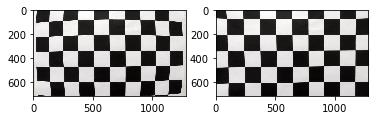

In [4]:
camera.calibrateCamera(chessboard_images)
idx=0
img = camera.undistort(chessboard_images.getChessboardImg(idx))
plt.subplot(121).imshow(chessboard_images.getChessboardImg(idx))
plt.subplot(122).imshow(img)

logging.shutdown()

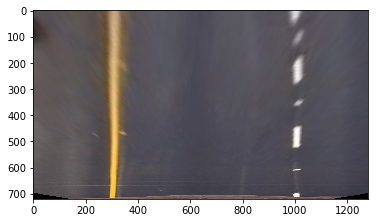

In [5]:
baseline_image = BaselineImage()
camera.updateM(baseline_image.src_points, baseline_image.dst_points)
warped = camera.warpPerspective(camera.baseline_image.img)
plt.imshow(warped)

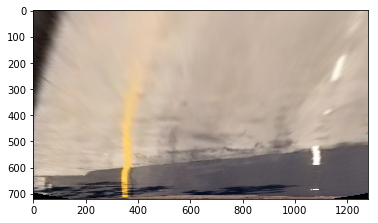

In [6]:
curved_img = mpimg.imread('test_images/test4.jpg')
warped = camera.warpPerspective(curved_img)
plt.imshow(warped)

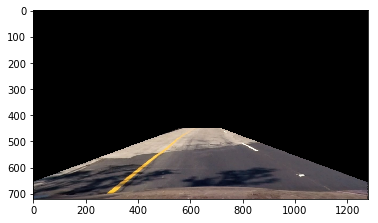

In [7]:
unwarped = camera.unwarpPerspective(warped)
plt.imshow(unwarped)

Gradient and Colorspace

In [8]:
'''
    def h_channel (self, img, t_min=18, t_max=50):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        
        mask = np.zeros_like(h_channel)
        mask[(t_min <= h_channel) & (h_channel <= t_max)] = 1
        
        return mask
    
    
    #--- we reuse the test_highlight_yellow_and_white above
    def yellow_white(self, img):

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        mask_yellow = cv2.inRange(hsv, yellow_range[0], yellow_range[1])
        mask_white  = cv2.inRange(hsv, white_range[0], white_range[1])

        mask = mask_yellow + mask_white

        return mask
yellow_range = [np.array([20,  70,   0]), 
                np.array([40, 255, 255])]

white_range  = [np.array([  0,  0, 180]), 
                np.array([179, 25, 255])]

        

'''


class LaneEdgeMasker:
    def __init__(self):
        
        return
    
    def Sobel_x(self, img, t_min=20, t_max=255):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0))
        sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
        
        mask = np.zeros_like(sobel_scaled)
        mask[(t_min <= sobel_scaled) & (sobel_scaled <= t_max)] = 1
        
        return mask
    
    def s_channel (self, img, t_min=125, t_max=255):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        
        mask = np.zeros_like(s_channel)
        mask[(t_min <= s_channel) & (s_channel <= t_max)] = 1
        
        return mask
    
masker = LaneEdgeMasker()



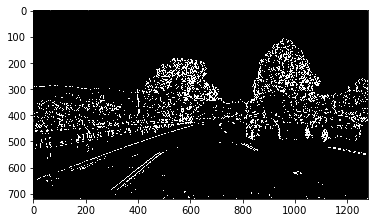

In [10]:
x_mask = masker.Sobel_x(curved_img)
plt.imshow(x_mask, cmap='gray')

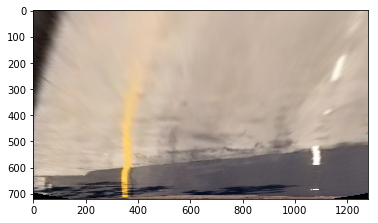

In [11]:
x_warped = camera.warpPerspective(x_mask)
plt.imshow(warped, cmap='gray')

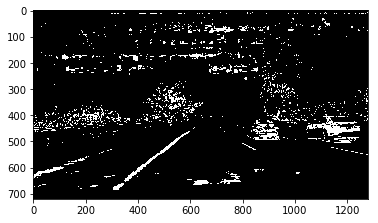

In [12]:
s_mask = masker.s_channel(curved_img)
plt.imshow(s_mask, cmap='gray')

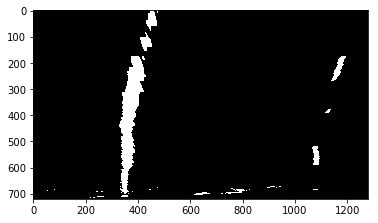

In [13]:
s_warped = camera.warpPerspective(s_mask)
plt.imshow(s_warped, cmap='gray')

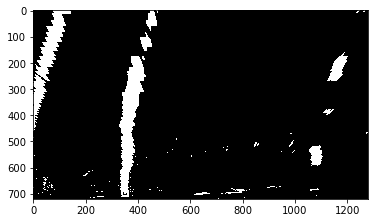

In [15]:
all_mask = s_warped | x_warped
plt.imshow(all_mask, cmap='gray')

Finding the lines

(1280,)


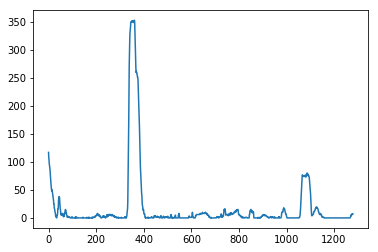

In [16]:
def hist(mask):
    
    bottom_half = mask[mask.shape[0] // 2:,:]
    hist = np.sum(bottom_half, axis=0)
    
    return hist

h = hist(all_mask)
plt.plot(h)
print (h.shape)
    
    

get starting points

In [17]:
mid_x = h.shape[0] //2

left_x_mid = np.argmax(h[:mid_x])
right_x_mid = mid_x + np.argmax(h[mid_x:])
print (left_x_mid, right_x_mid)
print (h[left_x_mid], h[right_x_mid])

361 1086
353 80


In [203]:
class SlidingWindow:
    
    def __init__(self, x_mid, target_ht, num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        #--- y1 = y2 - ht
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of poins found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        self.at_top = False
        
        return
    
    
    def slideUp (self):
        
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            if self.y1 - self.ht - 1 >= 0:
                self.y1 = self.y1 - self.ht - 1
            else:
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.at_top = True
    
    
    def findPoints(self, points_x, points_y):
        
        #--- mask in all points within window by x and y values
        x_bool_mask = (self.x1 <= points_x) & (points_x <= self.x2)
        y_bool_mask = (self.y1 <= points_y) & (points_y <= self.y2)
        
        #--- bit wise the x and y masks to get the actual points
        xy_bool_mask = (x_bool_mask) & (y_bool_mask)
        
        #--- apply mask to points_x and _y to filter out the points
        points_found_x = points_x[xy_bool_mask]
        points_found_y = points_y[xy_bool_mask]
        
        #--- update the midpoint if enough points found above threshold
        if len(points_found_x) >= self.numpoints_found_thresh:
            #--- must be INT! or 
            self.x_mid = np.int(np.average(points_found_x))
        
        return points_found_x, points_found_y
        


class Line:
    
    def __init__(self, x, y):
        
        #--- we solve for X!!! i.e. x = ay**2 + by + C
        n = 100
        print (x[:n])
        print (y[:n])
        while True:
            try:
                fit = np.polyfit(y, x, deg=2)
                break
            except:
                continue
        self.A = fit[0]   # coeff for y**2
        self.B = fit[1]   # coeff for y
        self.C = fit[2]   # constant
        
        return
    
    
    def generatePoints(self, img_ht):
        
        #--- generate y points from 0 to img_ht - 1
        y_line_points = np.array([float(y) for y in range(img_ht)])
                                 
        #--- calculate points based on x
        x_line_points = self.A * y_line_points**2 + self.B * y_line_points + self.C
        
        return x_line_points, y_line_points
        
        
class LineGenerator:
    
    def __init__(self, lane_warped_img_binary):
        
        self.left_window = None
        self.right_window = None
        self.img_binary = lane_warped_img_binary
        
        
    def findStartingX(self):
        
        y_mid = self.img_binary.shape[0] // 2
        img_binary_bottom_half = self.img_binary[y_mid:, :]
        
        hist    = np.sum(img_binary_bottom_half, axis=0)
        x_mid   = self.img_binary.shape[1] // 2
        
        x_left  = np.argmax(hist[:x_mid])
        x_right = np.argmax(hist[x_mid:]) + x_mid
        
        return (x_left, x_right)
    
    
    def getImagePoints(self):
        
        nonzero_points = np.nonzero(self.img_binary)
        #--- y (row) points come first!!!
        #--- x (col) points are in second!!!
        points_y = np.array(nonzero_points[0])
        points_x = np.array(nonzero_points[1])
        
        return points_x, points_y
        
        
    def findLines(self):
        
        plt.figure(figsize=(11, 6.5))

        #--- TODO: comment out or remove
        demo_img = np.dstack((self.img_binary * 255, self.img_binary * 255, self.img_binary * 255))
        
        x_left, x_right = self.findStartingX()
        image_points_x, image_points_y = self.getImagePoints()
        
        left_window  = SlidingWindow(x_left,  self.img_binary.shape[0])
        right_window = SlidingWindow(x_right, self.img_binary.shape[0])
        
        windows=[left_window, right_window]
        lines = []
        
        i = 0
        for window in windows:
            
            found_points_x = []
            found_points_y = []
            while not window.at_top:

                #--- TODO: comment out or remove
                cv2.rectangle (demo_img, (window.x1, window.y1), (window.x2, window.y2), (0,255,0), 2)
                
                found_x, found_y = window.findPoints(image_points_x, image_points_y)
                found_points_x.extend(found_x)
                found_points_y.extend(found_y)
                window.slideUp()
                    
            if found_points_x:
                if i == 0:
                    demo_img[found_points_y, found_points_x] = [255, 0, 0]
                else:
                    demo_img[found_points_y, found_points_x] = [0, 0, 255]
                line = Line(found_points_x, found_points_y)

            i += 1
                
            lines.append(line)
        
        for line in lines:
            x_line_points, y_line_points = line.generatePoints(self.img_binary.shape[0])
            print (x_line_points[:10], y_line_points[:10])
            plt.plot(x_line_points, y_line_points, color='yellow')
            
        plt.imshow(demo_img)
        
        return lines
                    
            
lineGenerator = LineGenerator(all_mask)       
                
        
            
            
    
    
    
    

[334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 334, 335, 336]
[632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 632, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 635, 635, 635

[<__main__.Line at 0x290d1903ac8>, <__main__.Line at 0x290deca7c50>]

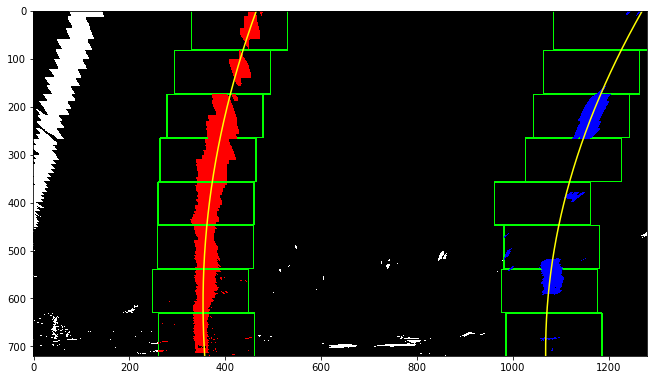

In [204]:
lineGenerator.findLines()

In [107]:
x = np.array([34, 35, 12 , 45, 56])
y = np.array([432, 123, 40 , 125, 456])
m = (12 <= x) & (x <= 35)
n = (430 <= y) & (y <= 435)
print (m)
print (n)
x_points = x[m & n]
y_points = y[m & n]
print (np.stack((x_points, y_points)))

[ True  True  True False False]
[ True False False False False]
[[ 34]
 [432]]


In [121]:
for i in range(10):
    print (i)

0
1
2
3
4
5
6
7
8
9


In [ ]:
img = mpimg.imread('test_images/straight_lines1.jpg')

ht = img.shape[0] - 1
wid = img.shape[1] - 1
midx = wid // 2
offsetx = 40
top = 425
bottom = ht

#--- XY coords
dx1 = 211
dx2 = 230


'''
source_points = np.float32 ([[592, 451],      [688, 451],     [1123, 719], [191, 719]])
# source_points = np.float32 ([[485, 530],      [805, 530],     [1104, 719], [211, 719]])

dest_points   = np.float32 ([[191, 0],      [1123, 0],     [1123, 719], [211, 719]])
# dest_points =   np.float32 ([[634 - dx1,   0],[644 + dx2, 0], [1104 - dx2, 719], [211 + dx1, 719]])

'''
source_points = np.float32 ([[592, 451],      [688, 451],     [1123, 719], [191, 719]])
# source_points = np.float32 ([[485, 530],      [805, 530],     [1104, 719], [211, 719]])

dest_points   = np.float32 ([[391, 0],      [923, 0],     [923, 719], [391, 719]])
# dest_points =   np.float32 ([[634 - dx1,   0],[644 + dx2, 0], [1104 - dx2, 719], [211 + dx1, 719]])



print (source_points)
print (dest_points)

plt.imshow(img)
for i in range(4):
    plt.plot(source_points[i][0], source_points[i][1], '.')



In [ ]:
M = cv2.getPerspectiveTransform(source_points, dest_points)
warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
# warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped)

In [ ]:



camera.getPerspectiveTransform(source_points, dest_points)
warped = camera.warpPerspective(img)
plt.imshow(warped)

In [ ]:
ret, corners = cv2.findChessboardCorners(gray, (9, 5), None)
if ret:
    print (corners.shape)

In [ ]:
#--- chessboard dimensions is in X by Y where X is columns, Y is rows

obj_points = np.zeros((9*5, 3), np.float32)
obj_points_2 = np.zeros((9*5, 3), np.float32)

#--- points are on the XY plane, so Z = 0
obj_points[:, :2] = np.mgrid[:9, :5].T.reshape(-1, 2)
obj_points_2[:, :2] = np.array([(x, y) for y in range(5) for x in range (9)])

# np.mgrid[:9, :5].T.reshape(-1, 2)
same = obj_points == obj_points_2
#print (same)
print (obj_points[:5])
print (obj_points_2[:5])

In [ ]:
mgrid = np.mgrid[:9, :5]
print (mgrid.shape)
print (mgrid)

In [ ]:
print (mgrid.T.shape)
print (mgrid.T)

In [ ]:
print (mgrid.T.reshape(-1, 2))
print (mgrid.T.shape)

In [ ]:
coords = mgrid.T.reshape(-1, 2)

In [ ]:
print (coords.shape)
print (corners.shape)
print (corners)

In [ ]:
img = cv2.drawChessboardCorners(img, (9, 5), corners, ret)
plt.imshow(img)

In [ ]:
shape = (4, 5, 3, 2, 8)
shape[2::2]